<a href="https://colab.research.google.com/github/guptapawan227/Capstone_AIML/blob/Ashish/Recreated_16thDec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
!pip3 install ftfy

Importing Libraries

In [40]:
# Using TensorFlow 1.x only in colab as found a issue with 2.3 version used by colab while working with DNN model fit. Did not observe any issue with Tensor flow 2.1 version on local jupyter enviornment.
%tensorflow_version 1.x

In [41]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import time, os, sys, itertools, re 
from PIL import Image
import warnings, pickle, string
from dateutil import parser
%matplotlib inline

# Data Visualization
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

from ftfy import fix_text, badness

# Traditional Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

'''# Sequential Modeling
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint'''

# Sequential Modeling
from sklearn import metrics
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU, Bidirectional, multiply, Permute, merge
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D, Activation, Embedding
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Reading the data from excel 

## Language Translation

#### Load the consolidated final translated pickle file which contains the language translations. The Process used for language translation is through google translate function in Google spreadsheets

In [ ]:
# Load the consolidated final translated pickle file 
#with open('/content/drive/MyDrive/Capstone/Final_Translated_combined.pkl','rb') as f:
with open('/content/drive/MyDrive/Capstone/final_translated.pkl','rb') as f:
    clean_data = pickle.load(f)

In [ ]:
clean_data.tail()

In [ ]:
assignment_group_cnt=clean_data['Assignment group'].value_counts()
assignment_group_cnt.describe()

In [ ]:
assignment_group_cnt.tail(50)

In [ ]:
#Removing groups with 4 or less records as those groups have been already added to rule matrix and these records are left overs

clean_data = clean_data[(clean_data["Assignment group"] != 'GRP_55') & (clean_data["Assignment group"] != 'GRP_66') & (clean_data["Assignment group"] != 'GRP_68') & (clean_data["Assignment group"] != 'GRP_72') & (clean_data["Assignment group"] != 'GRP_57') & (clean_data["Assignment group"] != 'GRP_56') & (clean_data["Assignment group"] != 'GRP_32')]

## Data Augmentation

In [ ]:
#Install NLPAug Package
!pip install nlpaug

In [ ]:
#Install dependencies for nlpaug
!pip install torch>=1.6.0 transformers>=4.0.0
!pip install nltk>=3.4.5

In [ ]:
#We will use Word Augmentation methods. nlpaug supports character, word and sentence level augmentation methods
import nlpaug.augmenter.word as naw

In [ ]:
#Word embedding augmentation method
aug1 = naw.WordEmbsAug(model_type='glove', model_path='glove.6B/glove.6B.50d.txt', action="substitute")


In [ ]:
aug2 = naw.WordEmbsAug(model_type='glove', model_path='glove.6B/glove.6B.50d.txt', action="insert")


In [ ]:
#Contextual Word augmentation method
aug3 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")


In [ ]:
aug4 = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")


In [ ]:
#Synonym Augmentation method using PPDB models downloaded from http://paraphrase.org/#/download
aug5 = naw.SynonymAug(aug_src='ppdb', model_path='ppdb-2.0-s-all')


In [ ]:
#!pip3 install nltk
import nltk 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

In [ ]:
#Create a new dataframe with records not in GRP_0
zero_dataframe = clean_data[clean_data["Assignment group"] == 'GRP_0']
new_dataframe = clean_data[clean_data["Assignment group"] != 'GRP_0']
zero_dataframe.head()


In [ ]:
#Create dataframe copies for different augmentation methods
new_dataframe2 = new_dataframe.copy()
new_dataframe3 = new_dataframe.copy()
new_dataframe4 = new_dataframe.copy()
new_dataframe5 = new_dataframe.copy()

In [ ]:
new_dataframe.shape, zero_dataframe.shape, new_dataframe2.shape, new_dataframe3.shape, new_dataframe4.shape, new_dataframe5.shape

In [ ]:
new_dataframe["Augmented_data"] = new_dataframe.apply(lambda x: aug1.augment(x['Translated_Text']),axis=1)
new_dataframe

In [ ]:
s = new_dataframe.apply(lambda x: pd.Series(x['Augmented_data']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Final_Text'
new_dataframe_aug = new_dataframe.drop(['New Description','Augmented_data', 'Clean_Description', 'Translated_Text'],axis=1).join(s)
new_dataframe_aug

In [ ]:
new_dataframe2["Augmented_data"] = new_dataframe2.apply(lambda x: aug2.augment(x['Translated_Text']),axis=1)
new_dataframe2

In [ ]:
s = new_dataframe2.apply(lambda x: pd.Series(x['Augmented_data']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Final_Text'
new_dataframe_aug2 = new_dataframe2.drop(['New Description','Augmented_data', 'Clean_Description', 'Translated_Text'],axis=1).join(s)
new_dataframe_aug2

In [ ]:
new_dataframe3["Augmented_data"] = new_dataframe3.apply(lambda x: aug3.augment(x['Translated_Text']),axis=1)
new_dataframe3

In [ ]:
s = new_dataframe3.apply(lambda x: pd.Series(x['Augmented_data']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Final_Text'
new_dataframe_aug3 = new_dataframe3.drop(['New Description','Augmented_data', 'Clean_Description', 'Translated_Text'],axis=1).join(s)
new_dataframe_aug3

In [ ]:
new_dataframe4["Augmented_data"] = new_dataframe4.apply(lambda x: aug4.augment(x['Translated_Text']),axis=1)
new_dataframe4

In [ ]:
s = new_dataframe4.apply(lambda x: pd.Series(x['Augmented_data']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Final_Text'
new_dataframe_aug4 = new_dataframe4.drop(['New Description','Augmented_data', 'Clean_Description', 'Translated_Text'],axis=1).join(s)
new_dataframe_aug4

In [ ]:
new_dataframe5["Augmented_data"] = new_dataframe5.apply(lambda x: aug5.augment(x['Translated_Text']),axis=1)
new_dataframe5

In [ ]:
s = new_dataframe5.apply(lambda x: pd.Series(x['Augmented_data']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Final_Text'
new_dataframe_aug5 = new_dataframe5.drop(['New Description','Augmented_data', 'Clean_Description', 'Translated_Text'],axis=1).join(s)
new_dataframe_aug5

In [ ]:
zero_dataframe = zero_dataframe.rename(columns={"Translated_Text": "Final_Text"})
zero_dataframe = zero_dataframe.drop(['New Description', 'Clean_Description'], axis = 1)


In [ ]:
zero_dataframe

In [ ]:
#Adding Original data (without Augmentation)
new_dataframe6 = clean_data[clean_data["Assignment group"] != 'GRP_0']
new_dataframe6 = new_dataframe6.rename(columns={"Translated_Text": "Final_Text"})
new_dataframe6 = new_dataframe6.drop(['New Description', 'Clean_Description'], axis = 1)
new_dataframe6

In [ ]:
dataframes=[new_dataframe_aug, new_dataframe_aug2, new_dataframe_aug3, new_dataframe_aug4, new_dataframe_aug5, zero_dataframe, new_dataframe6]
clean_data_result= pd.concat(dataframes)
clean_data_result

In [ ]:
#Remove duplicate rows after augmentation
clean_data_result = clean_data_result.drop_duplicates(subset='Final_Text', keep="first")

In [ ]:
# Serialize the Augmented dataset for later use
clean_data_result.to_csv('Interim_data.csv', index=False, encoding='utf_8_sig')
#with open('/content/Interim_data.pkl','wb') as f:
with open('/content/drive/MyDrive/Capstone/Interim_data.pkl','wb') as f:
    pickle.dump(clean_data_result, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the consolidated final translated pickle file 
#with open('/content/drive/MyDrive/Capstone/Interim_data.pkl','rb') as f:
with open('/content/drive/MyDrive/Capstone/Interim_data.pkl','rb') as f:
    clean_data_result = pickle.load(f)

In [ ]:
clean_data_result

## Stop words removal and Lemmatise text

In [ ]:
clean_data_result.isnull().sum()

In [ ]:
import re
import string
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) 

processed_all_documents = list()

for desc in clean_data_result['Final_Text']:
    word_tokens = word_tokenize(desc) 
    
    filtered_sentence = [] 

    # Removing Stopwords
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    words = ' '.join(filtered_sentence)
    processed_all_documents.append(words)  

In [ ]:
clean_data_result['Final_Text'] = processed_all_documents

In [ ]:
clean_data_result.head(50)

In [ ]:
clean_data_result.dropna()

In [ ]:
clean_data_result.isnull().sum()

In [ ]:
#Lemmatisation using spacy library
!pip install spacy

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz

In [ ]:
!pip3 install spacy

In [ ]:
# Need to run "python -m spacy download en" in anaconda prompt to avoid 'en' not found issue.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

clean_data_result['Final_Text'] = clean_data_result['Final_Text'].apply(lemmatize_text)

In [ ]:
clean_data_result

In [ ]:
clean_data_result1 = clean_data_result[clean_data_result['Final_Text'] != '']

In [ ]:
clean_data_result1

In [ ]:
assignment_group_cnt=clean_data_result1['Assignment group'].value_counts()
assignment_group_cnt.describe()

In [ ]:
assignment_group_cnt.tail(24)

In [ ]:
# Final data pkl file after augmentation, stopwords removal and lemmatisation
clean_data_result1.to_csv('Final_data.csv', index=False, encoding='utf_8_sig')
#with open('/content/Final_data.pkl','wb') as f:
with open('/content/drive/MyDrive/Capstone/Final_data.pkl','wb') as f:
    pickle.dump(clean_data_result1, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the translated pickle file 
with open('/content/drive/MyDrive/Capstone/Final_data.pkl','rb') as f:
#with open('/content/drive/MyDrive/Capstone/Final_data.pkl','rb') as f:
    clean_data = pickle.load(f)

In [ ]:
clean_data

## Manual inspection showed that groups having Monitoring tool emails and Job scheduler errors are dropping the accuracy as they cant be used for machine learning as no patterns. Moving them into 1 group.

In [ ]:
#Moving all the records coming from monitoring tool/job scheduler to one group

clean_data.loc[(clean_data['Final_Text'].astype(str).str.contains('scheduler')), 'Assignment group'] = "GRP_MonitoringTool"


In [ ]:
assignment_group_cnt=clean_data['Assignment group'].value_counts()
assignment_group_cnt.describe()

In [ ]:
assignment_group_cnt = clean_data['Assignment group'].value_counts().rename_axis('Grp_name').reset_index(name='counts')

In [ ]:
assignment_group_cnt 

In [ ]:
# Saving pkl file after creating new target group for job_scheduler emails
clean_data.to_csv('Final_data1.csv', index=False, encoding='utf_8_sig')
#with open('/content/Final_data.pkl','wb') as f:
with open('/content/drive/MyDrive/Capstone/Final_data1.pkl','wb') as f:
    pickle.dump(clean_data, f, pickle.HIGHEST_PROTOCOL)

## Resampling the groups having less than 500 records

In [ ]:
#Sory for the messy code, didnt have patience to write a lambda function. Splitting dataframes with < 500 records for resampling
temp_dataframe = clean_data[(clean_data["Assignment group"] == 'GRP_43') | (clean_data["Assignment group"] == 'GRP_46') | (clean_data["Assignment group"] == 'GRP_59') | (clean_data["Assignment group"] == 'GRP_49') | (clean_data["Assignment group"] == 'GRP_60') | (clean_data["Assignment group"] == 'GRP_51') | (clean_data["Assignment group"] == 'GRP_52') | (clean_data["Assignment group"] == 'GRP_65') | (clean_data["Assignment group"] == 'GRP_53') | (clean_data["Assignment group"] == 'GRP_39') | (clean_data["Assignment group"] == 'GRP_36') | (clean_data["Assignment group"] == 'GRP_50') | (clean_data["Assignment group"] == 'GRP_44') | (clean_data["Assignment group"] == 'GRP_47') | (clean_data["Assignment group"] == 'GRP_37') | (clean_data["Assignment group"] == 'GRP_27') | (clean_data["Assignment group"] == 'GRP_5') | (clean_data["Assignment group"] == 'GRP_1') | (clean_data["Assignment group"] == 'GRP_62') | (clean_data["Assignment group"] == 'GRP_23') | (clean_data["Assignment group"] == 'GRP_17') | (clean_data["Assignment group"] == 'GRP_48') | (clean_data["Assignment group"] == 'GRP_45') | (clean_data["Assignment group"] == 'GRP_21') | (clean_data["Assignment group"] == 'GRP_11') | (clean_data["Assignment group"] == 'GRP_22') | (clean_data["Assignment group"] == 'GRP_20') | (clean_data["Assignment group"] == 'GRP_42') | (clean_data["Assignment group"] == 'GRP_30') | (clean_data["Assignment group"] == 'GRP_15') | (clean_data["Assignment group"] == 'GRP_41') | (clean_data["Assignment group"] == 'GRP_28') | (clean_data["Assignment group"] == 'GRP_40') | (clean_data["Assignment group"] == 'GRP_26') | (clean_data["Assignment group"] == 'GRP_34') | (clean_data["Assignment group"] == 'GRP_6') | (clean_data["Assignment group"] == 'GRP_7') | (clean_data["Assignment group"] == 'GRP_31') | (clean_data["Assignment group"] == 'GRP_9') | (clean_data["Assignment group"] == 'GRP_10')]
temp_dataframe2 = clean_data[(clean_data["Assignment group"] != 'GRP_43') & (clean_data["Assignment group"] != 'GRP_46') & (clean_data["Assignment group"] != 'GRP_59') & (clean_data["Assignment group"] != 'GRP_49') & (clean_data["Assignment group"] != 'GRP_60') & (clean_data["Assignment group"] != 'GRP_51') & (clean_data["Assignment group"] != 'GRP_52') & (clean_data["Assignment group"] != 'GRP_65') & (clean_data["Assignment group"] != 'GRP_53') & (clean_data["Assignment group"] != 'GRP_39') & (clean_data["Assignment group"] != 'GRP_36') & (clean_data["Assignment group"] != 'GRP_50') & (clean_data["Assignment group"] != 'GRP_44') & (clean_data["Assignment group"] != 'GRP_47') & (clean_data["Assignment group"] != 'GRP_37') & (clean_data["Assignment group"] != 'GRP_27') & (clean_data["Assignment group"] != 'GRP_5') & (clean_data["Assignment group"] != 'GRP_1') & (clean_data["Assignment group"] != 'GRP_62') & (clean_data["Assignment group"] != 'GRP_23') & (clean_data["Assignment group"] != 'GRP_17') & (clean_data["Assignment group"] != 'GRP_48') & (clean_data["Assignment group"] != 'GRP_45') & (clean_data["Assignment group"] != 'GRP_21') & (clean_data["Assignment group"] != 'GRP_11') & (clean_data["Assignment group"] != 'GRP_22') & (clean_data["Assignment group"] != 'GRP_20') & (clean_data["Assignment group"] != 'GRP_42') & (clean_data["Assignment group"] != 'GRP_30') & (clean_data["Assignment group"] != 'GRP_15') & (clean_data["Assignment group"] != 'GRP_41') & (clean_data["Assignment group"] != 'GRP_28') & (clean_data["Assignment group"] != 'GRP_40') & (clean_data["Assignment group"] != 'GRP_26') & (clean_data["Assignment group"] != 'GRP_34') & (clean_data["Assignment group"] != 'GRP_6') & (clean_data["Assignment group"] != 'GRP_7') & (clean_data["Assignment group"] != 'GRP_31') & (clean_data["Assignment group"] != 'GRP_9') & (clean_data["Assignment group"] != 'GRP_10')]
temp_dataframe2

In [ ]:
assignment_group_cnt2 = temp_dataframe2['Assignment group'].value_counts().rename_axis('Grp_name').reset_index(name='counts')

In [ ]:
assignment_group_cnt2

In [ ]:
#resampling all groups having less than 500 records
from sklearn.utils import resample
clean_data_resampled = temp_dataframe[0:0]
for grp in temp_dataframe['Assignment group'].unique():
    temp_dataframe1 = temp_dataframe.apply(lambda x : True
            if str(temp_dataframe['Assignment group']) == grp else False, axis = 1)
    num_rows = len(temp_dataframe1[temp_dataframe1 == True].index) 
    if(num_rows < 500):
            temp_dataframeGrpDF = temp_dataframe[temp_dataframe['Assignment group'] == grp]
            resampled = resample(temp_dataframeGrpDF, replace=True, n_samples=500, random_state=123)
            clean_data_resampled = clean_data_resampled.append(resampled)

In [ ]:
clean_data_resampled

In [ ]:
#Concat dataframes post resampling
dataframes=[clean_data_resampled, temp_dataframe2]
clean_data_resampled= pd.concat(dataframes)
clean_data_resampled

In [ ]:
assignment_group_cnt3 = clean_data_resampled['Assignment group'].value_counts().rename_axis('Grp_name').reset_index(name='counts')
assignment_group_cnt3

In [ ]:
# Saving pkl file after resampling
clean_data_resampled.to_csv('Final_data_resampled.csv', index=False, encoding='utf_8_sig')
#with open('/content/Final_data.pkl','wb') as f:
with open('Final_data_resampled.pkl','wb') as f:
    pickle.dump(clean_data_resampled, f, pickle.HIGHEST_PROTOCOL)

# Load from here to save time. 

In [ ]:
# Load the translated pickle file. Load from here to save time. 
with open('/content/drive/MyDrive/Capstone/Final_data_resampled.pkl','rb') as f:
#with open('/content/drive/MyDrive/Capstone/Final_data.pkl','rb') as f:
    clean_data = pickle.load(f)

## Prepping Dataframe for Model Building

In [ ]:
clean_data

In [ ]:
'''# Import label encoder 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
clean_data['Assignment group LabelEncoded']= label_encoder.fit_transform(clean_data['Assignment group']) 
  


onehot_encoder = OneHotEncoder()
clean_data['Assignment group LabelEncoded'] = clean_data['Assignment group LabelEncoded'].values.reshape(len(clean_data['Assignment group LabelEncoded']), 1)
clean_data['Assignment group OneHotEncoded'] = onehot_encoder.fit_transform(clean_data[['Assignment group LabelEncoded']])
clean_data['Assignment group OneHotEncoded']'''

In [ ]:
# Import label encoder 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
clean_data['Assignment group LabelEncoded']= label_encoder.fit_transform(clean_data['Assignment group']) 

target_strings = label_encoder.inverse_transform(clean_data['Assignment group LabelEncoded'])
target_strings_list = np.unique(target_strings).tolist()
clean_data['Assignment group LabelEncoded']

In [ ]:
'''# Create a target categorical column
clean_data['Assignment group LabelEncoded'] = clean_data['Assignment group'].astype('category').cat.codes
clean_data.info()'''

In [ ]:
clean_data

In [ ]:
clean_data.isnull().sum()

In [ ]:
label_encoded_dict = dict(zip(clean_data['Assignment group'].unique(), clean_data['Assignment group LabelEncoded'].unique()))
label_encoded_dict

In [ ]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split
#Y = np.array(clean_data['Assignment group OneHotEncoded'])

X_train, X_test, y_train1, y_test1 = train_test_split(clean_data['Final_Text'], clean_data['Assignment group LabelEncoded'], test_size=0.3, random_state = 0, stratify=clean_data['Assignment group LabelEncoded'])
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train1.shape, y_test1.shape)

In [ ]:
#Using first method of TFIDF vectors feature extraction
Tfidf_vect = TfidfVectorizer(max_features=2500)
Tfidf_vect.fit(clean_data.Final_Text.astype(str))
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

In [ ]:
#using second method of count vectorizer for features extraction
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(max_features=2500)

X_BoW = CV.fit_transform(clean_data['Final_Text']).toarray()
y = clean_data['Assignment group LabelEncoded']

print("Shape of Input Feature :",np.shape(X_BoW))
print("Shape of Target Feature :",np.shape(y))

In [ ]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_BoW, y, test_size=0.3, random_state = 0, stratify=y)
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

In [53]:
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        model_history = clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=25, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the clasiffier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the clasiffier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred, target_names=target_strings_list)))

    
    if isDeepModel :
      plt.plot(model_history.history['acc'])
      plt.plot(model_history.history['val_acc'])
      plt.title(arch_name+' model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train','test'], loc='upper left')
      plt.show()

      plt.plot(model_history.history['loss'])
      plt.plot(model_history.history['val_loss'])
      plt.title(arch_name+' model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train','test'], loc='upper left')
      plt.show()
    

## Logistic Regression

In [ ]:
run_classification(LogisticRegression(C=5, penalty='l2', solver='liblinear'), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
run_classification(LogisticRegression(C=5, penalty='l2', solver='liblinear'), X_train, X_test, y_train, y_test)

## Naive Bayes Classifier

In [ ]:
run_classification(MultinomialNB(alpha=0, class_prior=None, fit_prior='True'), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
run_classification(MultinomialNB(alpha=0, class_prior=None, fit_prior='True'), X_train, X_test, y_train, y_test)

## K-nearest Neighbor

In [ ]:
run_classification(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance'), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
run_classification(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance'), X_train, X_test, y_train, y_test)

## Support Vector Machine (SVM)

In [ ]:
run_classification(LinearSVC(C=1), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
run_classification(LinearSVC(C=1), X_train, X_test, y_train, y_test)

## Decision Tree

In [ ]:
run_classification(DecisionTreeClassifier(criterion='gini', min_samples_leaf=2), X_train, X_test, y_train, y_test)

In [ ]:
run_classification(DecisionTreeClassifier(criterion='gini', min_samples_leaf=2), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

## Random Forest

In [ ]:
run_classification(RandomForestClassifier(criterion= 'entropy', n_estimators=100, random_state=0), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
run_classification(RandomForestClassifier(criterion= 'entropy', n_estimators=100, random_state=0), X_train, X_test, y_train, y_test)

## GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
run_classification(GradientBoostingClassifier(max_depth=15, n_estimators=50, random_state=42), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
run_classification(GradientBoostingClassifier(max_depth=15, n_estimators=50, random_state=42), X_train, X_test, y_train, y_test)

## XGBoosting

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
run_classification(XGBClassifier(n_estimators=50, max_depth=15), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
from xgboost import XGBClassifier
run_classification(XGBClassifier(n_estimators=50, max_depth=15), X_train, X_test, y_train, y_test)

## Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
run_classification(BaggingClassifier(n_estimators=100, random_state=10), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
from sklearn.ensemble import BaggingClassifier
run_classification(BaggingClassifier(n_estimators=100, random_state=10), X_train, X_test, y_train, y_test)

## Stacking

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('svr', make_pipeline(StandardScaler(with_mean=False), LinearSVC(random_state=42)))]

run_classification(StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier()), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)), ('svr', make_pipeline(StandardScaler(with_mean=False), LinearSVC(random_state=42)))]

run_classification(StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier()), X_train, X_test, y_train, y_test)

## Voting

In [ ]:
from sklearn.ensemble import VotingClassifier


estimators = [('rf', RandomForestClassifier(criterion= 'entropy', n_estimators=100, random_state=42)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')), ('bg', BaggingClassifier(n_estimators=100, random_state=42)), ('lsvc', LinearSVC(C=1, random_state=42))]

run_classification(VotingClassifier(estimators=estimators, voting='hard'), X_train_tfidf, X_test_tfidf, y_train1, y_test1)

In [ ]:
from sklearn.ensemble import VotingClassifier


estimators = [('rf', RandomForestClassifier(criterion= 'entropy', n_estimators=100, random_state=42)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')), ('bg', BaggingClassifier(n_estimators=100, random_state=42)), ('lsvc', LinearSVC(C=1, random_state=42))]

run_classification(VotingClassifier(estimators=estimators, voting='hard'), X_train, X_test, y_train, y_test)

## Deep Neural Networks

In [42]:
# Load the augmented data from pickle file 
with open('/content/drive/MyDrive/Capstone/Interim_data.pkl','rb') as f:
#with open('Interim_data.pkl','rb') as f:
    clean_data_DL = pickle.load(f)

In [6]:
clean_data_DL.loc[(clean_data_DL['Final_Text'].astype(str).str.contains('scheduler')), 'Assignment group'] = "GRP_MonitoringTool"


In [7]:
temp_dataframe3 = clean_data_DL[(clean_data_DL["Assignment group"] == 'GRP_43') | (clean_data_DL["Assignment group"] == 'GRP_46') | (clean_data_DL["Assignment group"] == 'GRP_59') | (clean_data_DL["Assignment group"] == 'GRP_49') | (clean_data_DL["Assignment group"] == 'GRP_60') | (clean_data_DL["Assignment group"] == 'GRP_51') | (clean_data_DL["Assignment group"] == 'GRP_52') | (clean_data_DL["Assignment group"] == 'GRP_65') | (clean_data_DL["Assignment group"] == 'GRP_53') | (clean_data_DL["Assignment group"] == 'GRP_39') | (clean_data_DL["Assignment group"] == 'GRP_36') | (clean_data_DL["Assignment group"] == 'GRP_50') | (clean_data_DL["Assignment group"] == 'GRP_44') | (clean_data_DL["Assignment group"] == 'GRP_47') | (clean_data_DL["Assignment group"] == 'GRP_37') | (clean_data_DL["Assignment group"] == 'GRP_27') | (clean_data_DL["Assignment group"] == 'GRP_5') | (clean_data_DL["Assignment group"] == 'GRP_1') | (clean_data_DL["Assignment group"] == 'GRP_62') | (clean_data_DL["Assignment group"] == 'GRP_23') | (clean_data_DL["Assignment group"] == 'GRP_17') | (clean_data_DL["Assignment group"] == 'GRP_48') | (clean_data_DL["Assignment group"] == 'GRP_45') | (clean_data_DL["Assignment group"] == 'GRP_21') | (clean_data_DL["Assignment group"] == 'GRP_11') | (clean_data_DL["Assignment group"] == 'GRP_22') | (clean_data_DL["Assignment group"] == 'GRP_20') | (clean_data_DL["Assignment group"] == 'GRP_42') | (clean_data_DL["Assignment group"] == 'GRP_30') | (clean_data_DL["Assignment group"] == 'GRP_15') | (clean_data_DL["Assignment group"] == 'GRP_41') | (clean_data_DL["Assignment group"] == 'GRP_28') | (clean_data_DL["Assignment group"] == 'GRP_40') | (clean_data_DL["Assignment group"] == 'GRP_26') | (clean_data_DL["Assignment group"] == 'GRP_34') | (clean_data_DL["Assignment group"] == 'GRP_6') | (clean_data_DL["Assignment group"] == 'GRP_7') | (clean_data_DL["Assignment group"] == 'GRP_31') | (clean_data_DL["Assignment group"] == 'GRP_9') | (clean_data_DL["Assignment group"] == 'GRP_10')]
temp_dataframe4 = clean_data_DL[(clean_data_DL["Assignment group"] != 'GRP_43') & (clean_data_DL["Assignment group"] != 'GRP_46') & (clean_data_DL["Assignment group"] != 'GRP_59') & (clean_data_DL["Assignment group"] != 'GRP_49') & (clean_data_DL["Assignment group"] != 'GRP_60') & (clean_data_DL["Assignment group"] != 'GRP_51') & (clean_data_DL["Assignment group"] != 'GRP_52') & (clean_data_DL["Assignment group"] != 'GRP_65') & (clean_data_DL["Assignment group"] != 'GRP_53') & (clean_data_DL["Assignment group"] != 'GRP_39') & (clean_data_DL["Assignment group"] != 'GRP_36') & (clean_data_DL["Assignment group"] != 'GRP_50') & (clean_data_DL["Assignment group"] != 'GRP_44') & (clean_data_DL["Assignment group"] != 'GRP_47') & (clean_data_DL["Assignment group"] != 'GRP_37') & (clean_data_DL["Assignment group"] != 'GRP_27') & (clean_data_DL["Assignment group"] != 'GRP_5') & (clean_data_DL["Assignment group"] != 'GRP_1') & (clean_data_DL["Assignment group"] != 'GRP_62') & (clean_data_DL["Assignment group"] != 'GRP_23') & (clean_data_DL["Assignment group"] != 'GRP_17') & (clean_data_DL["Assignment group"] != 'GRP_48') & (clean_data_DL["Assignment group"] != 'GRP_45') & (clean_data_DL["Assignment group"] != 'GRP_21') & (clean_data_DL["Assignment group"] != 'GRP_11') & (clean_data_DL["Assignment group"] != 'GRP_22') & (clean_data_DL["Assignment group"] != 'GRP_20') & (clean_data_DL["Assignment group"] != 'GRP_42') & (clean_data_DL["Assignment group"] != 'GRP_30') & (clean_data_DL["Assignment group"] != 'GRP_15') & (clean_data_DL["Assignment group"] != 'GRP_41') & (clean_data_DL["Assignment group"] != 'GRP_28') & (clean_data_DL["Assignment group"] != 'GRP_40') & (clean_data_DL["Assignment group"] != 'GRP_26') & (clean_data_DL["Assignment group"] != 'GRP_34') & (clean_data_DL["Assignment group"] != 'GRP_6') & (clean_data_DL["Assignment group"] != 'GRP_7') & (clean_data_DL["Assignment group"] != 'GRP_31') & (clean_data_DL["Assignment group"] != 'GRP_9') & (clean_data_DL["Assignment group"] != 'GRP_10')]
temp_dataframe4

,Caller,Assignment group,language,Final_Text
17,sigfdwcj reofwzlm,GRP_3,en,"though undocking interface, screen will not sa..."
31,kxsceyzo naokumlb,GRP_4,en,"gentles, have two devices that are trying to s..."
46,bpctwhsn kzqsbmtp,GRP_MonitoringTool,en,job Job_ had in job_scheduler last: needs Job_...
49,bpctwhsn kzqsbmtp,GRP_MonitoringTool,en,getting mm_zscr_dly_merktc failed in job_sched...
58,bpctwhsn kzqsbmtp,GRP_MonitoringTool,en,job mm_zscr_dly_merktc when and job_scheduler ...
...,...,...,...,...
8183,hugcadrn ixhlwdgt,GRP_2,en,please remove user hugcadrn ixhlwdgt (ralfteim...
8186,pvbomqht smfkuhwi,GRP_3,en,pc received multiple windows security updates ...
8189,mpihysnw wrctgoan,GRP_29,en,please contact ed pasgryowski (pasgryo) about ...
8193,cpmaidhj elbaqmtp,GRP_3,en,tablet needs reimaged due to multiple issues w...


In [8]:
from sklearn.utils import resample
clean_data_resampled2 = temp_dataframe3[0:0]
for grp in temp_dataframe3['Assignment group'].unique():
    temp_dataframe5 = temp_dataframe3.apply(lambda x : True
            if str(temp_dataframe3['Assignment group']) == grp else False, axis = 1)
    num_rows2 = len(temp_dataframe5[temp_dataframe5 == True].index) 
    if(num_rows2 < 500):
            temp_dataframeGrpDF1 = temp_dataframe3[temp_dataframe3['Assignment group'] == grp]
            resampled2 = resample(temp_dataframeGrpDF1, replace=True, n_samples=500, random_state=123)
            clean_data_resampled2 = clean_data_resampled2.append(resampled2)

In [9]:
dataframes=[clean_data_resampled2, temp_dataframe4]
clean_data_DL = pd.concat(dataframes)
clean_data_DL

,Caller,Assignment group,language,Final_Text
3574,spxqmiry zpwgoqju,GRP_1,en,HostName_: volume: / dev / ora_data encourages...
1590,jyoqwxhz clhxsoqy,GRP_1,en,HostName_: volume: /dev/SID_ora on server: Hos...
4783,pvlxjizg xzvlwqjc,GRP_1,en,hostname _ and hostname _ in listener is not a...
541,kbnfxpsy gehxzayq,GRP_1,en,considering ticket_no which corresponded fixed...
4454,mnlazfsr mtqrkhnx,GRP_1,en,'s shop_floor_app is intelligence: inaccessibl...
...,...,...,...,...
8183,hugcadrn ixhlwdgt,GRP_2,en,please remove user hugcadrn ixhlwdgt (ralfteim...
8186,pvbomqht smfkuhwi,GRP_3,en,pc received multiple windows security updates ...
8189,mpihysnw wrctgoan,GRP_29,en,please contact ed pasgryowski (pasgryo) about ...
8193,cpmaidhj elbaqmtp,GRP_3,en,tablet needs reimaged due to multiple issues w...


In [10]:
clean_data_DL.to_csv('Interim_data_resampled.csv', index=False, encoding='utf_8_sig')
#with open('/content/Final_data.pkl','wb') as f:
with open('/content/drive/MyDrive/Capstone/Interim_data_resampled.pkl','wb') as f:
    pickle.dump(clean_data_DL, f, pickle.HIGHEST_PROTOCOL)

# Start from here to save time

In [ ]:
# Load the augmented data from pickle file 
with open('/content/drive/MyDrive/Capstone/Interim_data_resampled.pkl','rb') as f:
#with open('Interim_data.pkl','rb') as f:
    clean_data_DL = pickle.load(f)

In [43]:
clean_data_DL.isnull().sum()

Caller              0
Assignment group    0
language            0
Final_Text          0
dtype: int64

In [44]:
clean_data_DL['Final_Text'] = clean_data_DL['Final_Text'].replace(np.nan, '', regex=True)

In [45]:
clean_data_DL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41252 entries, 3574 to 8194
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Caller            41252 non-null  object
 1   Assignment group  41252 non-null  object
 2   language          41252 non-null  object
 3   Final_Text        41252 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [46]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
clean_data_DL['Assignment group LabelEncoded']= label_encoder.fit_transform(clean_data_DL['Assignment group']) 

target_strings = label_encoder.inverse_transform(clean_data_DL['Assignment group LabelEncoded'])
target_strings_list = np.unique(target_strings).tolist()

clean_data_DL['Assignment group LabelEncoded'].unique()

array([ 1, 42, 52, 48,  3,  7,  9, 13, 14, 15, 16, 19, 20, 21, 54, 24, 25,
        2, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44,
       45, 46, 47, 49, 50, 51, 23, 31, 55, 53,  4,  6,  8, 10, 11, 12, 17,
        5, 22, 18, 26,  0])

In [47]:
label_encoded_dict = dict(zip(clean_data_DL['Assignment group'].unique(), clean_data_DL['Assignment group LabelEncoded'].unique()))
len(label_encoded_dict)

56

In [48]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_data_DL['Final_Text'], clean_data_DL['Assignment group LabelEncoded'], test_size=0.3, random_state = 0, stratify=clean_data_DL['Assignment group LabelEncoded'])
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (28876,) (12376,)
Shape of the test set: (28876,) (12376,)


### Create checkpoints function

In [49]:
#Path where you want to save the weights, model and checkpoints
model_path = "Weights/"
%mkdir Weights

# Define model callbacks
def call_backs(name):
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=3)
    model_checkpoint =  ModelCheckpoint(model_path + name + '_epoch{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=False,
                                                               mode='min',
                                                               period=1)
    return [model_checkpoint, early_stopping]

mkdir: cannot create directory ‘Weights’: File exists


## Deep Neural Networks (DNN)

In [17]:
# Function to build Neural Network
def Build_Model_DNN_Text(shape, nClasses, dropout=0.3):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [18]:
Tfidf_vect = TfidfVectorizer(max_features=2500)
Tfidf_vect.fit(clean_data_DL.Final_Text.astype(str))
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

# Instantiate the network
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 56)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1280512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_______________________________________

In [20]:
run_classification(model_DNN, X_train_tfidf, X_test_tfidf, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='DNN')



Train on 28876 samples, validate on 12376 samples
Epoch 1/25
28876/28876 [==============================] - 5s 169us/step - loss: 2.5223 - accuracy: 0.3905 - val_loss: 3.8746 - val_accuracy: 0.1097

Epoch 00001: val_loss improved from inf to 3.87463, saving model to Weights/DNN_epoch01_loss3.8746.h5
Epoch 2/25
28876/28876 [==============================] - 3s 91us/step - loss: 0.9240 - accuracy: 0.7376 - val_loss: 1.3673 - val_accuracy: 0.6116

Epoch 00002: val_loss improved from 3.87463 to 1.36734, saving model to Weights/DNN_epoch02_loss1.3673.h5
Epoch 3/25
28876/28876 [==============================] - 3s 92us/step - loss: 0.4619 - accuracy: 0.8665 - val_loss: 0.3718 - val_accuracy: 0.8921

Epoch 00003: val_loss improved from 1.36734 to 0.37175, saving model to Weights/DNN_epoch03_loss0.3718.h5
Epoch 4/25
28876/28876 [==============================] - 3s 94us/step - loss: 0.2826 - accuracy: 0.9172 - val_loss: 0.3012 - val_accuracy: 0.9205

Epoch 00004: val_loss improved from 0.3717

'model_DNN.fit(X_train_tfidf, y_train,\n                              validation_data=(X_test_tfidf, y_test),\n                              callbacks=call_backs("NN"),\n                              epochs=10,\n                              batch_size=128,\n                              verbose=2)\npredicted = model_DNN.predict(X_test_tfidf)'

### Extract Glove Embeddings

In [50]:
#download the glove embedding zip file from http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
from zipfile import ZipFile
# Check if it is already extracted else Open the zipped file as readonly
if not os.path.isfile('glove.6B/glove.6B.200d.txt'):
    #glove_embeddings = 'glove.6B.zip'
    glove_embeddings = '/content/drive/MyDrive/Capstone/glove.6B.zip'
    with ZipFile(glove_embeddings, 'r') as archive:
        archive.extractall('glove.6B')

# List the files under extracted folder
os.listdir('glove.6B')

['glove.6B.300d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt']

## Convolutional Neural Networks (CNN)

In [51]:
#gloveFileName = 'glove.6B/glove.6B.200d.txt'
gloveFileName = '/content/glove.6B/glove.6B.200d.txt'
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM=200
MAX_NB_WORDS=75000

# Function to generate Embedding
def loadData_Tokenizer(X_train, X_test,filename):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)


embedding_matrix = []

def buildEmbed_matrices(word_index,embedding_dim):
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])), "into shape",str(len(embedding_vector)),
                      " Please make sure your"" EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [52]:
# Generate Glove embedded datasets
X_train_Glove, X_test_Glove, word_index, embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

Found 44936 unique tokens.
(41252, 500)
Total 400001 word vectors.


In [54]:
def Build_Model_LSTM_Text(word_index, embeddings_matrix, nclasses,dropout=0.3):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    embedded_sequences = embedding_layer(sequence_input)
    lstm = Bidirectional(LSTM(128))(embedded_sequences)
    drop = Dropout(0.3)(lstm)
    dense = Dense(100,activation='relu')(drop)
    preds = Dense(nclasses, activation='softmax')(dense)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
model_CNN_LSTM = Build_Model_LSTM_Text(word_index,embedding_matrix, 56)
run_classification(model_CNN_LSTM, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='CNN_LSTM')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 200)          8987400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_11 (Dense)             (None, 56)                5656      
Total params: 9,355,652
Trainable params: 9,355,652
Non-trainable params: 0
___________________________________________________

In [25]:
def Build_Model_CNN_Text(word_index, embeddings_matrix, nclasses,dropout=0.3):
    model = Sequential()
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_batch1 = BatchNormalization()(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_batch1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_batch2 = BatchNormalization()(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_batch2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

In [26]:
# Train the network and run classification
model_CNN = Build_Model_CNN_Text(word_index,embedding_matrix, 56)
run_classification(model_CNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='CNN')

Filter   5

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 200)     8987400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 499, 128)     51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 498, 128)     76928       embedding_1[0][0]                
________________________________________________________________________________

## Recurrent Neural Networks (RNN) --> Gated Recurrent Unit (GRU)

In [36]:
def Build_Model_RNN_Text(word_index, embeddings_matrix, nclasses,dropout=0.5):
    model = Sequential()
    hidden_layer = 3
    gru_node = 128
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int64'))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    #print(gru_node)
    '''for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())'''
    model.add(GRU(gru_node))
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    
    print(model.summary())
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 200)          8987400   
_________________________________________________________________
gru (GRU)                    (None, 128)               126336    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_9 (Dense)              (None, 56)                5656      
Total params: 9,132,292
Trainable params: 9,132,292
Non-trainable params: 0
_________________________________________________________________
None
Train on 28876 samples, validate on 12376 samples
Epoch 1/25
28800/28876 [============================>.]

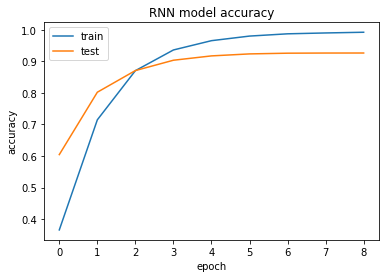

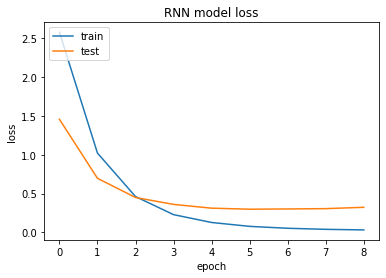

In [37]:
# Train the network and run classification
model_RNN = Build_Model_RNN_Text(word_index,embedding_matrix, 56)
run_classification(model_RNN, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='RNN')

## RNN with Bidirectional LSTM network

In [34]:
EMBEDDING_DIM = 200
#gloveFileName = 'glove.6B/glove.6B.100d.txt'
gloveFileName = '/content/glove.6B/glove.6B.200d.txt'

def Build_Model_LTSM_Text(word_index, embeddings_matrix, nclasses):
    kernel_size = 10
    filters = 100
    pool_size = 2
    gru_node = 128
    
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int64'))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embeddings_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    #model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(Conv1D(filters, kernel_size, activation='relu'))
    #model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(Conv1D(filters, kernel_size, activation='relu'))
    #model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Bidirectional(LSTM(gru_node)))
    #model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    #model.add(Bidirectional(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2)))
    #model.add(Bidirectional(LSTM(gru_node, recurrent_dropout=0.2)))
    model.add(Dropout(0.3))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(nclasses,activation='softmax'))
    #model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    print(model.summary())
    return model

Found 44936 unique tokens.
(41252, 500)
Total 400001 word vectors.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 200)          8987400   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 491, 100)          200100    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 245, 100)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 245, 100)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 100)          100100    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 118, 100)          0         
_____________________________________________________

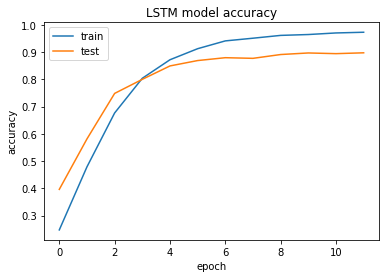

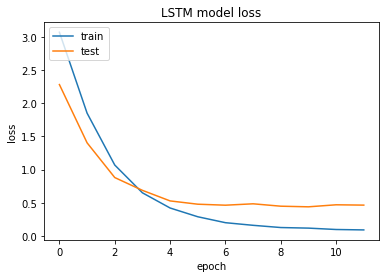

In [35]:
X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test,gloveFileName)
embedding_matrix = buildEmbed_matrices(word_index,EMBEDDING_DIM)

model_LTSM = Build_Model_LTSM_Text(word_index,embedding_matrix, 56                                                                                                                                                                        )
run_classification(model_LTSM, X_train_Glove, X_test_Glove, y_train, y_test,pipelineRequired = False,isDeepModel=True, arch_name='LSTM')